In [1]:
import pandas as pd
import numpy as np
import tqdm

import os
import shutil
import sys

from sklearn.model_selection import train_test_split

import tensorflow as tf
from   tensorflow import keras

Origin of the datasets: <br>
https://www.kaggle.com/homayoonkhadivi/medical-diagnosis-histopathologic-cancer-cnn

In [2]:
root_path = 'F:/mo444/histopathologic-cancer-detection/'

In [3]:
#I have a problem with memory using GPU(GTX 1050 TI) with 4GB, so this piece of code solve the problem to alocate memory

physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Invalid device or cannot modify virtual devices once initialized.")
    pass

In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1



In [5]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6011433452560602282
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 2911292622
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12830889464083360034
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:05:00.0, compute capability: 6.1"
]


In [6]:
#Importing the pre trained networks used in this work
from keras.applications.efficientnet import EfficientNetB0
from keras.applications.efficientnet import EfficientNetB7
from keras.applications.xception import Xception
from keras.applications.densenet import DenseNet121

# from tensorflow.keras.applications.efficientnet import preprocess_input

from keras.models import Sequential, model_from_json
from keras.layers import Dense, Flatten, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K

from numpy import array2string

## Sepair imagens by label

In [7]:
import glob
from glob import glob
from tensorflow.keras.preprocessing import image
from mpl_toolkits.axes_grid1 import ImageGrid

import matplotlib.pyplot as plt

#Lib to shuffler the dataset
from sklearn.utils import shuffle

In [8]:
#Reading the labels of samples
df= pd.read_csv(f'{root_path}train_labels.csv')

In [9]:
print(f'The dataset have {df.index.size} samples (imagens with and wihout cancer)')

The dataset have 220025 samples (imagens with and wihout cancer)


In [10]:
print(f"The dataset have {round(df['label'].value_counts(normalize=True)[0] * 100, 2)} of samples without cancer " +
     f"and {round(df['label'].value_counts(normalize=True)[1] * 100, 2)} with cancer")

The dataset have 59.5 of samples without cancer and 40.5 with cancer


In [11]:
#Define the folder where the data is saved (we dont save em C:/ because the dataset is huge)
orig_dir = 'F:/mo444/histopathologic-cancer-detection/train_imagens/train/'

In [12]:
# Shuffling the data 
filenames_shuffled, y_labels_one_hot_shuffled = shuffle(df['id'].values, df['label'].values)

In [13]:
# Sepair the data in training and validation (60% train and 40% validation)
X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(
    filenames_shuffled, y_labels_one_hot_shuffled, test_size=0.4, random_state=1)

### Data generation customized for load data in batchs to memory <br>
https://medium.com/@mrgarg.rajat/training-on-large-datasets-that-dont-fit-in-memory-in-keras-60a974785d71

In [14]:
from skimage.io import imread
from skimage.transform import resize

In [15]:
class My_Custom_Generator(keras.utils.Sequence) :

    def __init__(self, image_filenames, labels, batch_size) :
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


    #Sepair data in batch size, normalize the image values and resize to (96,96,3)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        return np.array([
                resize(imread(f'{orig_dir}{str(file_name)}.tif'), (96, 96, 3))
                   for file_name in batch_x])/255.0, np.array(batch_y)

In [16]:
#Batch size of each epoch during the training
batch_size = 64

my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size)

## Xception

### Creating and training the model

In [17]:
keras.backend.clear_session() # clean memory from previous models 

model = Sequential()

model.add(Xception(weights='imagenet', pooling='avg', include_top=False))

#MLP
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation="relu", kernel_initializer="he_normal", name="hidden1"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(512, activation='relu',kernel_initializer='he_normal',name="hidden2"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal',name="hidden3",
                            kernel_regularizer=keras.regularizers.l2(0.02)))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(124, activation='relu',kernel_initializer='he_normal',name="hidden4",
                            kernel_regularizer=keras.regularizers.l2(0.02)))
# model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(2, activation="softmax", name = "decision"))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 2048)              20861480  
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
hidden1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
batch_normalization_4 (Batch (None, 1024)              4096      
_________________________________________________________________
hidden2 (Dense)              (None, 512)               524800    
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

In [19]:
#Optimizers that was tested
# opt =  keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
# opt =  keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)
opt =  keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

#Set the number of epochs
num_epochs   = 10

#Compiling the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

# Define a learning rate schedule as a callback function
def exponential_decay(epoch):
    return(0.01*0.1**(epoch/num_epochs))

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay)

#Training and validation process
history      = model.fit(my_training_batch_generator,
                    steps_per_epoch = int(X_train_filenames.shape[0] // batch_size),
                    epochs = num_epochs,
                    verbose = 1,
                    validation_data = my_validation_batch_generator,
                    callbacks=[lr_scheduler],
                    validation_steps = int(X_val_filenames.shape[0] // batch_size))

C:\Users\stiva\AppData\Local\Temp/ipykernel_16904/629412471.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


Epoch 1/10
2062/2062 [==============================] - 1699s 819ms/step - loss: 0.7652 - accuracy: 0.7994 - val_loss: 0.9342 - val_accuracy: 0.6128
Epoch 2/10
2062/2062 [==============================] - 1624s 787ms/step - loss: 0.4225 - accuracy: 0.8827 - val_loss: 0.5012 - val_accuracy: 0.8242
Epoch 3/10
2062/2062 [==============================] - 1739s 843ms/step - loss: 0.2976 - accuracy: 0.9096 - val_loss: 0.6920 - val_accuracy: 0.6770
Epoch 4/10
2062/2062 [==============================] - 1751s 849ms/step - loss: 0.2417 - accuracy: 0.9225 - val_loss: 0.5987 - val_accuracy: 0.7617
Epoch 5/10
2062/2062 [==============================] - 1642s 796ms/step - loss: 0.1967 - accuracy: 0.9389 - val_loss: 0.2187 - val_accuracy: 0.9274
Epoch 6/10
2062/2062 [==============================] - 1680s 814ms/step - loss: 0.1571 - accuracy: 0.9517 - val_loss: 0.2067 - val_accuracy: 0.9334
Epoch 7/10
2062/2062 [==============================] - 1767s 857ms/step - loss: 0.1238 - accuracy: 0.9629

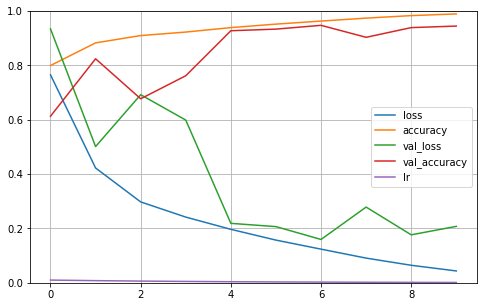

In [20]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('train_history_xception.png')
plt.show()

In [21]:
model.save("final_project_all_exception.h5")

F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Efficient Net

In [17]:
keras.backend.clear_session() # clean memory from previous models 

model = Sequential()

#Feature Extraction
model.add(EfficientNetB0(weights='imagenet', pooling='avg', include_top=False))

#MLP
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation="relu", kernel_initializer="he_normal", name="hidden1"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(512, activation='relu',kernel_initializer='he_normal',name="hidden2"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal',name="hidden3",
                            kernel_regularizer=keras.regularizers.l2(0.02)))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(124, activation='relu',kernel_initializer='he_normal',name="hidden4",
                            kernel_regularizer=keras.regularizers.l2(0.02)))

model.add(keras.layers.Dense(2, activation="softmax", name = "decision"))

In [18]:
#Optimizers that was tested
# opt =  keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
# opt =  keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)
opt =  keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

#Set the number of epochs
num_epochs   = 10

#Compiling the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

# Define a learning rate schedule as a callback function
def exponential_decay(epoch):
    return(0.01*0.1**(epoch/num_epochs))

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay)
early_stop = keras.callbacks.EarlyStopping(monitor='loss', patience=2)

#Training and validation process
history      = model.fit(my_training_batch_generator,
                    steps_per_epoch = int(X_train_filenames.shape[0] // batch_size),
                    epochs = num_epochs,
                    verbose = 1,
                    validation_data = my_validation_batch_generator,
                    callbacks=[lr_scheduler, early_stop],
                    validation_steps = int(X_val_filenames.shape[0] // batch_size))

C:\Users\stiva\AppData\Local\Temp/ipykernel_11048/629412471.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


Epoch 1/10
1031/1031 [==============================] - 1428s 1s/step - loss: 0.8625 - accuracy: 0.5926 - val_loss: 0.6756 - val_accuracy: 0.5949
Epoch 2/10
1031/1031 [==============================] - 1430s 1s/step - loss: 0.6752 - accuracy: 0.5950 - val_loss: 0.6751 - val_accuracy: 0.5949
Epoch 3/10
1031/1031 [==============================] - 1376s 1s/step - loss: 0.6752 - accuracy: 0.5950 - val_loss: 0.6750 - val_accuracy: 0.5949
Epoch 4/10
1031/1031 [==============================] - 1381s 1s/step - loss: 0.6751 - accuracy: 0.5949 - val_loss: 0.6751 - val_accuracy: 0.5949
Epoch 5/10
1031/1031 [==============================] - 1370s 1s/step - loss: 0.6751 - accuracy: 0.5950 - val_loss: 0.6751 - val_accuracy: 0.5949
Epoch 6/10
1031/1031 [==============================] - 1368s 1s/step - loss: 0.6751 - accuracy: 0.5950 - val_loss: 0.6750 - val_accuracy: 0.5949
Epoch 7/10
1031/1031 [==============================] - 1400s 1s/step - loss: 0.6751 - accuracy: 0.5949 - val_loss: 0.6751 -

### Evalution of the model

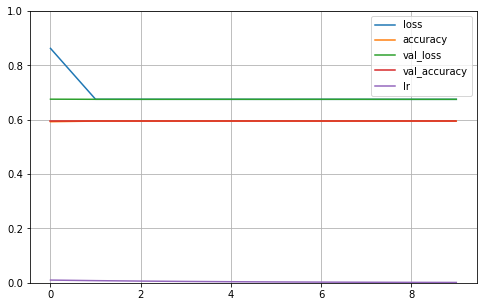

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('train_history_efficient.png')
plt.show()

In [20]:
model.save("final_project_all_efficient.h5")

F:\stiva\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


## Dense Net

In [84]:
keras.backend.clear_session() # clean memory from previous models 

model = Sequential()

#Feature Extraction
model.add(DenseNet121(weights='imagenet', pooling='avg', include_top=False))
# model.layers[0].trainable = False

#MLP
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1024, activation="relu", kernel_initializer="he_normal", name="hidden1"))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(512, activation='relu',kernel_initializer='he_normal',name="hidden2"))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(256, activation='relu',kernel_initializer='he_normal',name="hidden3",
                            kernel_regularizer=keras.regularizers.l2(0.02)))

model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(124, activation='relu',kernel_initializer='he_normal',name="hidden4",
                            kernel_regularizer=keras.regularizers.l2(0.02)))

model.add(keras.layers.Dense(2, activation="softmax", name = "decision"))

In [85]:
#Optimizers that was tested
# opt =  keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, nesterov=True)
# opt =  keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)
opt =  keras.optimizers.Adam(learning_rate=1e-3, beta_1=0.9, beta_2=0.999)

#Set the number of epochs
num_epochs   = 10

#Compiling the model
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

# Define a learning rate schedule as a callback function
def exponential_decay(epoch):
    return(0.01*0.1**(epoch/num_epochs))

lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay)

#Training and validation process
history      = model.fit(my_training_batch_generator,
                    steps_per_epoch = int(X_train_filenames.shape[0] // batch_size),
                    epochs = num_epochs,
                    verbose = 1,
                    validation_data = my_validation_batch_generator,
                    callbacks=[lr_scheduler],
                    validation_steps = int(X_val_filenames.shape[0] // batch_size))

C:\Users\stiva\AppData\Local\Temp/ipykernel_16904/629412471.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


Epoch 1/10
2062/2062 [==============================] - 2124s 1s/step - loss: 0.7287 - accuracy: 0.8304 - val_loss: 0.7363 - val_accuracy: 0.7184
Epoch 2/10
2062/2062 [==============================] - 1692s 821ms/step - loss: 0.4259 - accuracy: 0.8740 - val_loss: 1.2435 - val_accuracy: 0.6711
Epoch 3/10
2062/2062 [==============================] - 1386s 672ms/step - loss: 0.3093 - accuracy: 0.9050 - val_loss: 0.4734 - val_accuracy: 0.8063
Epoch 4/10
2062/2062 [==============================] - 1404s 681ms/step - loss: 0.2476 - accuracy: 0.9210 - val_loss: 0.3834 - val_accuracy: 0.8921
Epoch 5/10
2062/2062 [==============================] - 1396s 677ms/step - loss: 0.2181 - accuracy: 0.9310 - val_loss: 0.3819 - val_accuracy: 0.8368
Epoch 6/10
2062/2062 [==============================] - 1434s 696ms/step - loss: 0.1829 - accuracy: 0.9409 - val_loss: 0.5653 - val_accuracy: 0.7900
Epoch 7/10
2062/2062 [==============================] - 1387s 673ms/step - loss: 0.1594 - accuracy: 0.9481 - 

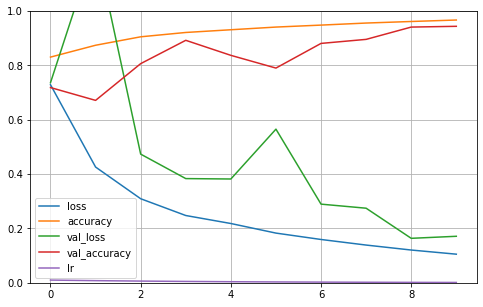

In [86]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.savefig('train_history_desenet.png')
plt.show()

In [87]:
model.save("final_project_desenet.h5")

## Model Evaluation

In [17]:
#Define the folder where the data is saved (we dont save em C:/ because the dataset is huge)
test_orig_dir = 'F:/mo444/histopathologic-cancer-detection/test_imagens/test/'

In [18]:
class My_Custom_Generator_test(keras.utils.Sequence) :

    def __init__(self, image_filenames, batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


    #Sepair data in batch size, normalize the image values and resize to (96,96,3)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]

        return np.array([
                resize(imread(f'{test_orig_dir}{str(file_name)}.tif'), (96, 96, 3))
                   for file_name in batch_x])/255.0

In [19]:
#https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
#How read the files names fro ma folder
from os.path import isfile, join
from os import listdir
X_text_filenames = [f for f in listdir(test_orig_dir) if isfile(join(test_orig_dir, f))]

In [20]:
#Create the list with name of samples in the fold
X_text_filenames = [image.split('.')[0] for image in X_text_filenames]

In [21]:
#Create the dataloader to load from disk to the memory in during the batch
my_test_batch_generator = My_Custom_Generator_test(X_text_filenames, batch_size)

In [22]:
#Load the model
model_exception = keras.models.load_model("final_project_desenet.h5")

In [ ]:
#Predict the class for each test sample
model_exception_result = model_exception.predict(my_test_batch_generator)

In [90]:
#Find the class from the softmax output
test_labels = [np.argmax(result) for result in model_exception_result]

In [91]:
#Create the dataframe to save the csv in format accpet by Kaggle
df_results_test = pd.DataFrame()
df_results_test['id'] = X_text_filenames
df_results_test['label'] = test_labels

df_results_test.to_csv('sample_submission_densenet.csv',index=False)

### Results in Kaggle

Xception result <br>
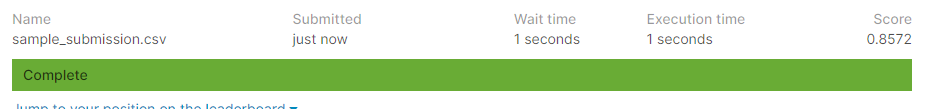

Efficient Result <br>
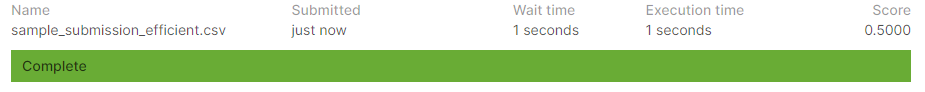

Densenet Result <br>
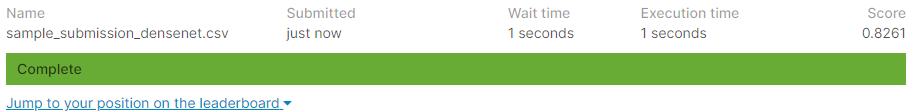

## Explanaiton of the model

In [23]:
#Library to explanation of pixels
import shap

In [50]:
class My_Custom_Generator_shap(keras.utils.Sequence) :

    def __init__(self, image_filenames, batch_size) :
        self.image_filenames = image_filenames
        self.batch_size = batch_size

    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int)


    #Sepair data in batch size, normalize the image values and resize to (96,96,3)
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]

        return np.array([
                resize(imread(f'{orig_dir}{str(file_name)}.tif'), (96, 96, 3))
                   for file_name in batch_x])/255.0

In [51]:
#Code explanation get from the github of the library shap in the examples of 'how to use'
#Create the dataloader to load from disk to the memory in during the batch
my_shap_batch_generator = My_Custom_Generator_shap(X_train_filenames, batch_size)

In [52]:
#Get some image from training dataset to evaluet shap
background = next(iter(my_shap_batch_generator))

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Read the test samples

In [27]:
from PIL import Image
# img = Image.fromarray(data, 'RGB')

In [37]:
def normalize_image(X):
    normalized = (X - np.min(X))/np.ptp(X)
    return normalized

In [38]:
def f(X):
    """
    Data and apply the predict function
    """
    tmp = normalize_image(X)
#     tmp = X.copy()
    return model_exception.predict(tmp)

In [39]:
class_names = ['sem metástase', 'com metástase']

In [58]:
#Selecting the images and putting in a unique np.array to
#be evaluated by SHAP
x0 = background[0] #Wit cancer (1)
x1 = background[3] #Without cancet (0)
x2 = np.array([np.array(x0), np.array(x1)])

In [41]:
#Define the masker that ocult part of image to analysis
masker_telea = shap.maskers.Image("inpaint_telea", x1.shape)

# By default the Partition explainer is used for all  partition explainer
explainer = shap.Explainer(f, masker_telea, output_names=class_names)

In [42]:
#Evalue the shap model, when in each image the mask are applied 500 times
#To cover all spance and generate the 'squares' with color blue and pink.
shap_values = explainer(x2, max_evals=500, outputs=shap.Explanation.argsort.flip[:1])

  0%|          | 0/248 [00:00<?, ?it/s]

invalid value encountered in true_divide
Partition explainer:  50%|███████████████████████████████████▌                                   | 1/2 [00:00<?, ?it/s]

  0%|          | 0/248 [00:00<?, ?it/s]

Partition explainer: 3it [00:25, 12.60s/it]                                                                            


In [43]:
#Define how many row will ploted
toplot = range(x2.shape[0])

#Normalize the data to show the pixels in the image
Xplot = np.array([(x2[t] - np.min(x2[t]))/np.ptp(x2[t]) for t in toplot])

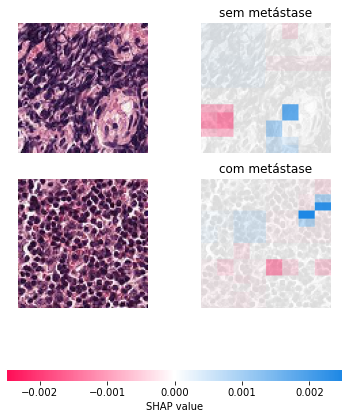

In [44]:
#Ploting the shap values
shap.image_plot(shap_values, pixel_values=Xplot,labels=class_names)

In [59]:
#Predict the shap direct in the classifier
model_exception.predict(x2)

array([[0.98863494, 0.01136501],
       [0.32349887, 0.67650115]], dtype=float32)